<a href="https://colab.research.google.com/github/kadilrahman/emotion_recognition/blob/master/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview:

We performed the Emotion Recognition Task using Random Forest Classifier, Deep Neural Networks Model, Convolutional Neural Networks (CNN), Residual Network Model (ResNet), Convolutional Recurrent Neural Network Model (CRNN), and Transformer Model. One of the main challenges we faced is the lack of standard datasets and benchmarks along with the huge size of the dataset which made it hard for us to process it and execute the algorithms. In terms of recommendations, we would highly recommend carefully preprocess the data and select appropriate features that capture the relevant emotional cues. We also find that it is important to tune in appropriate parameters/hyperparameters so as to obtain optimum performance.

In [ ]:
Angry=0
Disgust=1
Fear=2
Happy=3
Sad=4
Surprise=5
Neutral=6

In [ ]:
import itertools
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

from keras import models
from keras import layers
from keras import optimizers
from keras import Sequential
from keras import regularizers
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import VGG16, VGG19
from keras.layers import Flatten, Dropout, Reshape,Dense
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import model_from_json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/DL/my_emotion_test.csv')
df_train = pd.read_csv('/content/drive/MyDrive/DL/my_emotion_train.csv')

# Method:

The given dataset primarily consists of two sub-datasets namely training and testing. The training dataset consists of 3 features namely “id”, “emotion” and “pixels” wherein “id” represents the index number, “emotion” consists of all the types of emotions namely Angry, Disgust, Fear, Happy, Sad, Surprise and Neutral and “pixels” representing the data pertaining to the respective emotions. The testing dataset consists of primarily 2 features namely “id” and “pixels” which are used as an input to predict the “emotion” of the input variables. Given this data, we learnt that it is essential to carefully preprocess the data so as to obtain optimum efficiency.

In [ ]:
df_train.head()

,id,emotion,pixels
0,9415,6,29 16 18 18 18 20 19 18 17 17 17 18 17 18 17 1...
1,19109,3,126 154 167 181 188 194 195 194 196 195 198 20...
2,21523,2,169 220 218 208 184 144 72 73 143 183 203 210 ...
3,2076,3,60 64 72 80 83 83 80 82 89 106 114 125 125 127...
4,13957,3,174 148 121 97 78 70 62 57 54 54 42 58 40 64 1...


In [ ]:
df_test.head()

,id,pixels
0,640,123 109 128 142 103 113 145 179 178 158 177 19...
1,6081,41 41 41 41 42 42 42 45 39 16 10 10 7 9 9 5 8 ...
2,11137,248 228 211 197 194 181 195 180 185 189 193 18...
3,6793,158 181 192 200 193 179 133 167 219 211 164 19...
4,5932,195 185 166 165 149 98 89 83 65 183 75 65 67 6...


In [ ]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29000 entries, 0 to 28999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       29000 non-null  int64 
 1   emotion  29000 non-null  int64 
 2   pixels   29000 non-null  object
dtypes: int64(2), object(1)
memory usage: 679.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6887 entries, 0 to 6886
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6887 non-null   int64 
 1   pixels  6887 non-null   object
dtypes: int64(1), object(1)
memory usage: 107.7+ KB


## Pre-processing

For pre-processing, we firstly check if there are any missing/null values in the dataset post which we prepared the pixel data from training and testing data frames to be used as an input for the ML models. Secondly, for train, test and validation, we have only split the training dataset into training and validation sets.

Additionally, for pre-processing the data, we have split the “pixels” feature and reshaped the input images in the size 48x48 and we have also reshaped this feature based on every model’s requirements so as to better train the models and obtain the desired output. We have also used One-hot Encoding in some of the models as it was necessary for the model to improve its performance.



In [ ]:
# Define image dimensions
img_rows, img_cols = 48, 48
input_shape = (img_rows, img_cols, 1)

In [ ]:
X_train = df_train['pixels'].str.split(' ').apply(pd.Series).astype(float).values
y_train = df_train['emotion']
X_test = df_test['pixels'].str.split(' ').apply(pd.Series).astype(float).values

In [ ]:
#Spliting train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#class_map = {class_name: i for i, class_name in enumerate(class_names)}
#unique_labels = np.unique(df_train['emotion'])
#class_map = {str(label): index for index, label in enumerate(unique_labels)}

class_map = {class_name: i for i, class_name in enumerate(class_names)}
unique_labels = np.unique(df_train['emotion'])
class_map = {index: class_names[int(label)] for index, label in enumerate(unique_labels)}

In [ ]:
for label in set(y_train):
 print(f"{label}: {class_names[label]}")

0: Angry
1: Disgust
2: Fear
3: Happy
4: Sad
5: Surprise
6: Neutral


In [ ]:
X_train.shape

(23200, 2304)

In [ ]:
# Reshape the train and test
X_train = X_train.reshape(-1, img_rows, img_cols, 1)
X_test = X_test.reshape(-1, img_rows, img_cols, 1)
X_val = X_val.reshape(-1, img_rows, img_cols, 1)

In [ ]:
X_train.shape

(23200, 48, 48, 1)

In [ ]:
X_test.shape

(6887, 48, 48, 1)

## Data augmentation

Moving on, we have implemented data augmentation for our preprocessing which we executed by setting up an Image Data Generator object with various data augmentation parameters which we used to generate augmented images for model training.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(X_train)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(23200, 48, 48, 1)
(23200,)


# Models

## Standard ML Baseline:  Random Forest Classifier



Simple Machine Learning Baseline Model: We have used Random Forest Classifier for this task. Random Forest Classifier is a popular machine learning algorithm that is well-suited for classification tasks. We have chosen it mainly due to its ability to handle complex relationships, robustness to noise and outliers, feature importance estimation, and ensemble learning capabilities.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train.reshape(X_train.shape[0], -1), y_train)


RandomForestClassifier(random_state=42)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6887 entries, 0 to 6886
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6887 non-null   int64 
 1   pixels  6887 non-null   object
dtypes: int64(1), object(1)
memory usage: 107.7+ KB


In [ ]:
# Prediction
test_preds = rfc.predict(X_test.reshape(X_test.shape[0], -1))
print("Random Forest Test accuracy:", test_preds)

final = pd.DataFrame(columns=['id', 'emotion'])
final['id'] = df_test['id']
final['emotion'] = test_preds
final.to_csv('submission.csv', index=False)

Random Forest Test accuracy: [3 3 5 ... 3 4 0]


In [ ]:
val_preds = rfc.predict(X_val.reshape(X_val.shape[0], -1))
# y_val
len(val_preds)

5800

In [ ]:
val_acc = accuracy_score(y_val, val_preds)
val_acc

0.45120689655172413

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
mse = mean_squared_error(y_val, val_preds)
std_dev = np.std(val_preds)
print("MSE:", mse)
print("Standard Deviation:", std_dev)

MSE: 4.255862068965517
Standard Deviation: 1.4901676860210582


In [ ]:
# Define the input shape
input_shape = (48, 48, 1)

# Define the number of output classes
num_classes = 7

## Deep NN model and CNN

We have used Convolutional Neural Network as our Deep Neural Network Model. It is a type of neural network commonly used for image and video classification tasks. We chose it mainly due to its ability to handle complex relationships between input features and output labels, and their high accuracy in a wide range of image and speech recognition tasks.

In [ ]:
#DNN

# Define the different configurations to try
configs = [ {"units": 64, "dropout_rate": 0.2},
           {"units": 128, "dropout_rate": 0.3},
           {"units": 256, "dropout_rate": 0.4},
           {"units": 64, "dropout_rate": 0.2, "hidden_layers": 2},
           {"units": 128, "dropout_rate": 0.3, "hidden_layers": 2}]


In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical


# Load and preprocess the data
# Replace 'df_train' and 'df_test' with your actual data
X_train = df_train['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' '))
X_train = np.vstack(X_train.values)
X_train = X_train.reshape(-1, 48, 48, 1) / 255.0
y_train = to_categorical(df_train['emotion'], num_classes=num_classes)

X_test = df_test['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' '))
X_test = np.vstack(X_test.values)
X_test = X_test.reshape(-1, 48, 48, 1) / 255.0

In [ ]:
# Loop through each configuration and train a model
for config in configs:
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    for i in range(config.get("hidden_layers", 1)):
        model.add(layers.Dense(config["units"], activation='relu'))
        model.add(layers.Dropout(config["dropout_rate"]))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print the model summary
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 16928)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               2166912   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                      

In [ ]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)

Epoch 1/2
725/725 [==============================] - 13s 5ms/step - loss: 1.7565 - accuracy: 0.2800 - val_loss: 1.5952 - val_accuracy: 0.3895
Epoch 2/2
725/725 [==============================] - 4s 6ms/step - loss: 1.5983 - accuracy: 0.3679 - val_loss: 1.4991 - val_accuracy: 0.4322


In [ ]:
# Evaluate on validation set
test_preds = model.predict(X_test)

216/216 [==============================] - 1s 2ms/step


In [ ]:
test_preds_classes = np.argmax(test_preds, axis=1)
final = pd.DataFrame(columns=['id', 'emotion'])
final['id'] = df_test['id']
final['emotion'] = test_preds_classes
final.to_csv('DNN submission.csv', index=False)

In [ ]:
print(X_val.shape)

(5800, 48, 48, 1)


In [ ]:
print(X_train.shape)

(29000, 48, 48, 1)


In [ ]:
print(X_test.shape)

(6887, 48, 48, 1)


In [ ]:
print(y_val.shape)

(5800,)


In [ ]:
DNN_val_preds = model.predict(X_val)
# y_val
len(DNN_val_preds)

182/182 [==============================] - 0s 2ms/step


5800

In [ ]:
# Convert y_val to one-hot encoded format
y_val_categorical = to_categorical(y_val)

In [ ]:
from sklearn.metrics import accuracy_score

val_acc = accuracy_score(y_val_categorical.argmax(axis=1), DNN_val_preds.argmax(axis=1))
val_acc

0.31189655172413794

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val_categorical, DNN_val_preds)
std_dev = np.std(DNN_val_preds)
print("DNN_MSE:", mse)
print("DNN Std:", std_dev)

DNN_MSE: 0.18900993
DNN Std: 0.3393619


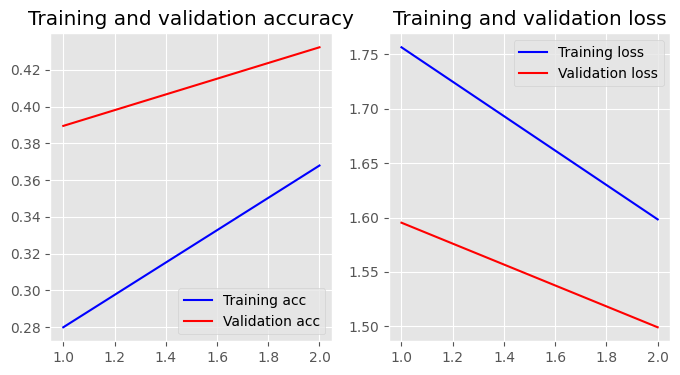

In [ ]:
plt.style.use('ggplot')
def plot_history(history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 x = range(1, len(acc) + 1)
 plt.figure(figsize=(8, 4))
 plt.subplot(1, 2, 1)
 plt.plot(x, acc, 'b', label='Training acc')
 plt.plot(x, val_acc, 'r', label='Validation acc')
 plt.title('Training and validation accuracy')
 plt.legend()
 plt.subplot(1, 2, 2)
 plt.plot(x, loss, 'b', label='Training loss')
 plt.plot(x, val_loss, 'r', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
plot_history(history)

**Parameter Used**

Deep Neural Network (DNN): We have used 5 configuartion and different hyperparameter for the DNN model which are “filters”, “kernel_size”, “pool_size”, “dropout_rate”, and “dense_units”. We used these to train and evaluate DNN model to find the best performing model for this task.

# CNN

In [ ]:
# Reshape the label arrays
y_train = np.argmax(y_train, axis=1)
#y_val = np.argmax(y_val, axis=1)

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential

# Define the model
model = Sequential([
    # First convolutional layer
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional layer
    Conv2D(128, (5, 5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third convolutional layer
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the output from convolutional layers
    Flatten(),

    # Dense layers with dropout
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer with 7 classes for the 7 emotions
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=1, validation_split=0.2)

725/725 [==============================] - 15s 15ms/step - loss: 2.2566 - accuracy: 0.2384 - val_loss: 1.8156 - val_accuracy: 0.2557


In [ ]:
# Evaluate on validation set
cnn_test_preds = model.predict(X_test)

216/216 [==============================] - 1s 4ms/step


In [ ]:
test_preds_classes = np.argmax(cnn_test_preds, axis=1)
final = pd.DataFrame(columns=['id', 'emotion'])
final['id'] = df_test['id']
final['emotion'] = test_preds_classes
final.to_csv('CNN submission.csv', index=False)

In [ ]:
CNN_val_preds = model.predict(X_val)
# y_val
len(CNN_val_preds)

182/182 [==============================] - 1s 3ms/step


5800

In [ ]:
val_acc = accuracy_score(y_val_categorical.argmax(axis=1), CNN_val_preds.argmax(axis=1))
val_acc

0.25051724137931036

In [ ]:
mse = mean_squared_error(y_val_categorical, CNN_val_preds)
std_dev = np.std(CNN_val_preds)
print("MSE:", mse)
print("Standard Deviation:", std_dev)

MSE: 0.11836726
Standard Deviation: 0.061687652


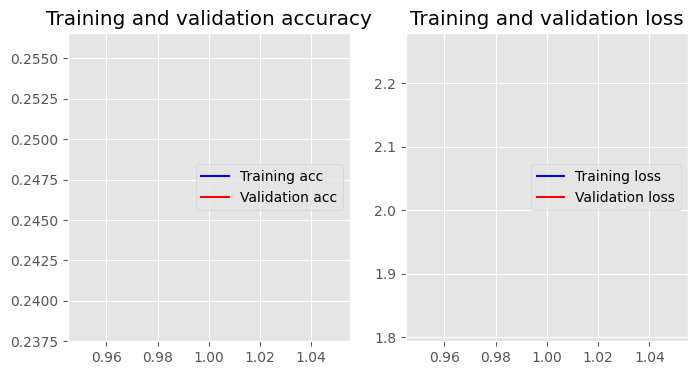

In [ ]:
plt.style.use('ggplot')
def plot_history(history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 x = range(1, len(acc) + 1)
 plt.figure(figsize=(8, 4))
 plt.subplot(1, 2, 1)
 plt.plot(x, acc, 'b', label='Training acc')
 plt.plot(x, val_acc, 'r', label='Validation acc')
 plt.title('Training and validation accuracy')
 plt.legend()
 plt.subplot(1, 2, 2)
 plt.plot(x, loss, 'b', label='Training loss')
 plt.plot(x, val_loss, 'r', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
plot_history(history)

**Parameter used**

Convolutional Neural Networks (CNN): We have used this model by inculcating the respective parameters. The model has a total of 7 layers, including 3 convulational layers, 3 dense layers, and an output layer with the first convolutional layer having 64 filters with a size of (3,3) followed by batch normalization and a max pooling layer with a pool size of (2,2) and a consistent dropout rate of 0.25. The second and third layer consists of 128 and 512 layers respectively with the output layer having two dense layers with 256 and 128 units respectively with each layer having a dropout rate of 0.5. Finally, the output layer consists of 7 units for each class of emotions and uses softmax.

# Complex NN:

 We have chosen Residual Network(ResNet), Transformer and Convolutional Recurrent Neural Network (CRNN) models for this task.

##  Transformer Model:

Transformer is a neural network that is commonly used for natural language processing tasks. They are designed mainly to handle sequential data and identify dependencies between the input sequence. We have used it because it is efficient in handling tasks involving sequential datasets.

In [ ]:
#Transformer
from keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout, Input
from keras.models import Model
from keras.layers import Layer

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.feed_forward_dim = feed_forward_dim
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embed_dim)
        self.feed_forward = Sequential([
            Dense(self.feed_forward_dim, activation='relu'),
            Dense(self.embed_dim)
        ])
        self.layer_norm_1 = LayerNormalization()
        self.layer_norm_2 = LayerNormalization()
        self.dropout_1 = Dropout(rate=self.dropout_rate)
        self.dropout_2 = Dropout(rate=self.dropout_rate)
        super().build(input_shape)

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout_1(attn_output)
        out1 = self.layer_norm_1(inputs + attn_output)
        feed_forward_output = self.feed_forward(out1)
        feed_forward_output = self.dropout_2(feed_forward_output)
        return self.layer_norm_2(out1 + feed_forward_output)

In [ ]:
# Define the input shape
input_shape = (48, 48, 1)

# Define the number of classes
num_classes = 7

# Define the input layer
inputs = Input(shape=input_shape)

In [ ]:
from keras.utils import to_categorical

# Assuming y_train and y_val are the targets/labels for training and validation sets respectively
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

In [ ]:
# Reshape the input to a sequence of vectors
x = Reshape((input_shape[0] * input_shape[1], input_shape[2]))(inputs)

# Apply the Transformer layer
x = TransformerBlock(embed_dim=64, num_heads=4, feed_forward_dim=64, dropout_rate=0.1)(x)

# Flatten the output of the Transformer layer
x = Flatten()(x)

# Define the output layer
outputs = Dense(num_classes, activation='softmax')(x)


In [ ]:
# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 reshape (Reshape)           (None, 2304, 1)           0         
                                                                 
 transformer_block (Transfor  (None, 2304, 64)         6211      
 merBlock)                                                       
                                                                 
 flatten_6 (Flatten)         (None, 147456)            0         
                                                                 
 dense_15 (Dense)            (None, 7)                 1032199   
                                                                 
Total params: 1,038,410
Trainable params: 1,038,410
Non-trainable params: 0
___________________________________________________

In [ ]:
# Train the model
history = model.fit(X_train, y_train_one_hot, batch_size=16, validation_data=(X_val, y_val_one_hot), epochs=1)

1813/1813 [==============================] - 391s 213ms/step - loss: 1.9779 - accuracy: 0.1967 - val_loss: 1.8491 - val_accuracy: 0.2505


In [ ]:
tranformer_test_preds = model.predict(X_test)

216/216 [==============================] - 34s 153ms/step


In [ ]:
test_preds_classes = np.argmax(tranformer_test_preds, axis=1)
final = pd.DataFrame(columns=['id', 'emotion'])
final['id'] = df_test['id']
final['emotion'] = test_preds_classes
final.to_csv('transformer submission.csv', index=False)

In [ ]:
transformer_val_preds = model.predict(X_val)
# y_val
len(transformer_val_preds)

182/182 [==============================] - 28s 153ms/step


5800

In [ ]:
val_acc = accuracy_score(y_val_categorical.argmax(axis=1), transformer_val_preds.argmax(axis=1))
val_acc

In [ ]:
mse = mean_squared_error(y_val_categorical, transformer_val_preds)
std_dev = np.std(transformer_val_preds)
print("MSE:", mse)
print("Standard Deviation:", std_dev)

MSE: 0.11963789
Standard Deviation: 0.07808984


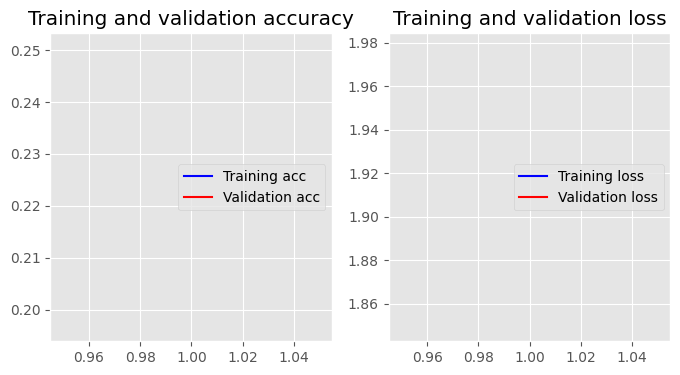

In [ ]:
plt.style.use('ggplot')
def plot_history(history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 x = range(1, len(acc) + 1)
 plt.figure(figsize=(8, 4))
 plt.subplot(1, 2, 1)
 plt.plot(x, acc, 'b', label='Training acc')
 plt.plot(x, val_acc, 'r', label='Validation acc')
 plt.title('Training and validation accuracy')
 plt.legend()
 plt.subplot(1, 2, 2)
 plt.plot(x, loss, 'b', label='Training loss')
 plt.plot(x, val_loss, 'r', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
plot_history(history)

## Convolutional Recurrent Neural Networks (CRNN):

Lastly, we have used CRNN as our final model or the task. CRNN is a neural network model that combines the strengths of both convolutional neural networks and recurrent neural networks. It is efficient is tasks involving sequential data with spatial structure such as image classification due to which we have chosen it.

In [ ]:
#CRNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, BatchNormalization, Reshape, Flatten, TimeDistributed, Activation

# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


In [ ]:
# Reshape output of convolutional layers to fit into LSTM
model.add(Reshape((-1, 128)))

In [ ]:
# LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dropout(0.25))

In [ ]:
# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Print the summary of the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 batch_normalization_4 (Batc  (None, 44, 44, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                      

In [ ]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train_one_hot, batch_size=32), validation_data=(X_val, y_val_one_hot), epochs=200)



Epoch 1/200
907/907 [==============================] - 34s 26ms/step - loss: 1.7010 - accuracy: 0.3098 - val_loss: 2.0097 - val_accuracy: 0.1755
Epoch 2/200
907/907 [==============================] - 24s 26ms/step - loss: 1.4790 - accuracy: 0.4304 - val_loss: 2.1451 - val_accuracy: 0.1971
Epoch 3/200
907/907 [==============================] - 24s 26ms/step - loss: 1.3825 - accuracy: 0.4778 - val_loss: 1.9030 - val_accuracy: 0.2917
Epoch 4/200
907/907 [==============================] - 23s 25ms/step - loss: 1.3305 - accuracy: 0.5024 - val_loss: 2.1156 - val_accuracy: 0.2852
Epoch 5/200
907/907 [==============================] - 23s 25ms/step - loss: 1.2893 - accuracy: 0.5163 - val_loss: 1.9208 - val_accuracy: 0.3626
Epoch 6/200
907/907 [==============================] - 23s 26ms/step - loss: 1.2669 - accuracy: 0.5247 - val_loss: 1.7485 - val_accuracy: 0.3336
Epoch 7/200
907/907 [==============================] - 22s 24ms/step - loss: 1.2404 - accuracy: 0.5382 - val_loss: 2.3407 - val_ac

In [ ]:
CRNN_test_preds = model.predict(X_test)

216/216 [==============================] - 2s 7ms/step


In [ ]:
test_preds_classes = np.argmax(CRNN_test_preds, axis=1)
final = pd.DataFrame(columns=['id', 'emotion'])
final['id'] = df_test['id']
final['emotion'] = test_preds_classes
final.to_csv('CRNN submission.csv', index=False)

In [ ]:
CRNN_val_preds = model.predict(X_val)
# y_val
len(CRNN_val_preds)

182/182 [==============================] - 1s 4ms/step


5800

In [ ]:
val_acc = accuracy_score(y_val_categorical.argmax(axis=1), CRNN_val_preds.argmax(axis=1))
val_acc

0.20844827586206896

In [ ]:
mse = mean_squared_error(y_val_categorical, CRNN_val_preds)
std_dev = np.std(CRNN_val_preds)
print("MSE:", mse)
print("Standard Deviation:", std_dev)

MSE: 0.16326702
Standard Deviation: 0.23740701


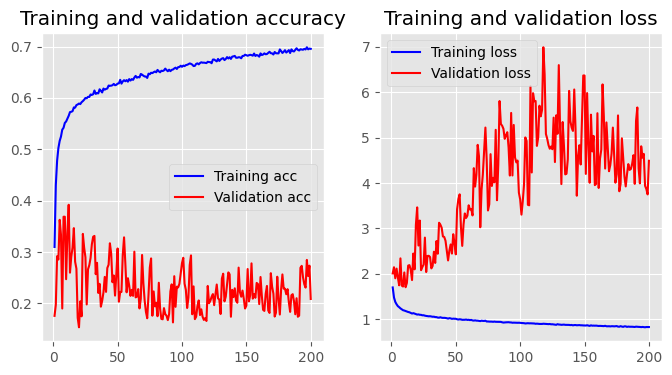

In [ ]:
plt.style.use('ggplot')
def plot_history(history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 x = range(1, len(acc) + 1)
 plt.figure(figsize=(8, 4))
 plt.subplot(1, 2, 1)
 plt.plot(x, acc, 'b', label='Training acc')
 plt.plot(x, val_acc, 'r', label='Validation acc')
 plt.title('Training and validation accuracy')
 plt.legend()
 plt.subplot(1, 2, 2)
 plt.plot(x, loss, 'b', label='Training loss')
 plt.plot(x, val_loss, 'r', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
plot_history(history)

**Parameter used**

Convolutional Recurrent Neural Network (CRNN): The parameters we used to execute the given model were prominently a convolutional layer followed by a LSTM layer with 12 units and return sequences set to True followed by a dropout layer. Furthermore, we added another LSTM layer with 64 units followed by another dropout layer.

## Residual Network (ResNet):

ResNet is a deep neural network which uses skip connections that allow the network to learn residual functions instead of directly learning the mapping between input and output. We have mainly considered to use it due to its ability to show excellence in image recognition tasks. One of its cardinal strength is to effectively train deep neural networks with hundreds of layers by addressing the problem of vanishing gradients that can occur during training.

In [ ]:
#ResNet
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from keras.models import Model

# Clear the session and reset the graph
tf.keras.backend.clear_session()

def residual_block(x, filters, kernel_size, strides=1, activation='relu'):
    # Shortcut path
    shortcut = x

    # First convolutional layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Second convolutional layer
    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Residual connection
    if strides != 1 or shortcut.shape[3] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Activation(activation)(x + shortcut)

    return x

In [ ]:
def ResNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=64, kernel_size=3, strides=1)
    x = residual_block(x, filters=64, kernel_size=3, strides=1)
    x = residual_block(x, filters=64, kernel_size=3, strides=1)

    x = residual_block(x, filters=128, kernel_size=3, strides=2)
    x = residual_block(x, filters=128, kernel_size=3, strides=1)
    x = residual_block(x, filters=128, kernel_size=3, strides=1)

    x = residual_block(x, filters=256, kernel_size=3, strides=2)
    x = residual_block(x, filters=256, kernel_size=3, strides=1)
    x = residual_block(x, filters=256, kernel_size=3, strides=1)

    x = residual_block(x, filters=512, kernel_size=3, strides=2)
    x = residual_block(x, filters=512, kernel_size=3, strides=1)
    x = residual_block(x, filters=512, kernel_size=3, strides=1)

    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Define the model
    model = Model(inputs=inputs, outputs=x)

    return model

In [ ]:
# Create the model
model = ResNet(input_shape=(48, 48, 1), num_classes=7)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(datagen.flow(X_train, y_train_one_hot, batch_size=32),
                    validation_data=(X_val, y_val_one_hot),
                    epochs=2)

Epoch 1/2
907/907 [==============================] - 37s 40ms/step - loss: 0.8690 - accuracy: 0.6748 - val_loss: 758.6752 - val_accuracy: 0.1064
Epoch 2/2
907/907 [==============================] - 43s 48ms/step - loss: 0.8541 - accuracy: 0.6793 - val_loss: 996.5957 - val_accuracy: 0.2507


In [ ]:
ResNet_test_preds = model.predict(X_test)

216/216 [==============================] - 3s 10ms/step


In [ ]:
test_preds_classes = np.argmax(ResNet_test_preds, axis=1)
final = pd.DataFrame(columns=['id', 'emotion'])
final['id'] = df_test['id']
final['emotion'] = test_preds_classes
final.to_csv('ReNet submission.csv', index=False)

In [ ]:
ResNet_val_preds = model.predict(X_val)
# y_val
len(ResNet_val_preds)

182/182 [==============================] - 2s 10ms/step


5800

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
mse = mean_squared_error(y_val_categorical, transformer_val_preds)
std_dev = np.std(transformer_val_preds)
print("MSE:", mse)
print("Standard Deviation:", std_dev)

MSE: 0.11963789
Standard Deviation: 0.07808984


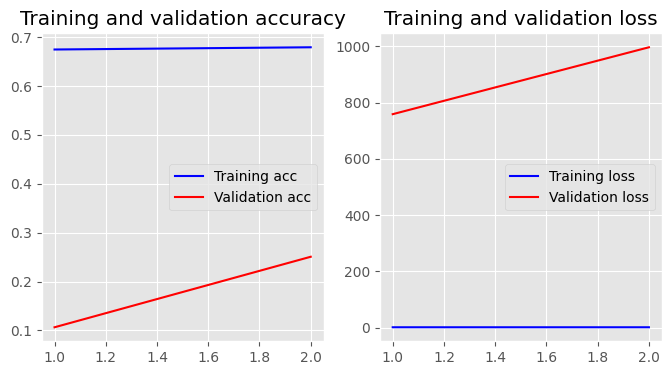

In [ ]:
plt.style.use('ggplot')
def plot_history(history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 x = range(1, len(acc) + 1)
 plt.figure(figsize=(8, 4))
 plt.subplot(1, 2, 1)
 plt.plot(x, acc, 'b', label='Training acc')
 plt.plot(x, val_acc, 'r', label='Validation acc')
 plt.title('Training and validation accuracy')
 plt.legend()
 plt.subplot(1, 2, 2)
 plt.plot(x, loss, 'b', label='Training loss')
 plt.plot(x, val_loss, 'r', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
plot_history(history)

**Parameter used:**

Residual Network (ResNet): The parameters used in this are mainly that the residual block contains 2 convolutional layers with batch normalization and activation functions applied to each layer. The output of the second layer is thereon added to the shortcut path, which is the input tensor passed to the residual block. This returns the desired output tensor. Furthermore, the model takes into consideration 64 filters followed by batch normalization, ReLu activation and max pooling.

All the above mentioned parameters were carefully tuned so as to maximize the efficiency of the respective models so as to obtain optimum accuracy.

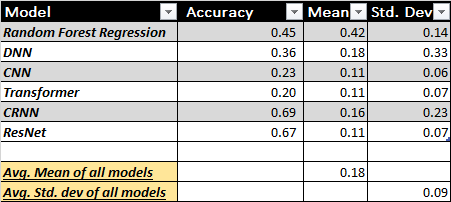

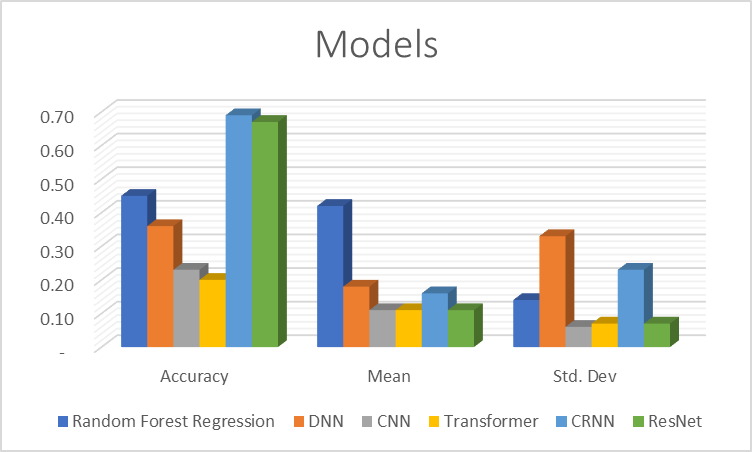

# Results:

According to our results, we can conclude that Convolutional Recurrent Neural Networks Model (CRNN) is the best performing model having an accuracy of 0.69.  We achieved such a high performance primarily because of Data Augmentation. We have used data augmentation in this model which helps in increasing the diversity of training data, improving the generalization of the model as well as in producing efficient and robust models. We have computed the mean and standard deviations for all the models used which include Random Forest Classifier Model, Deep Neural Networks Model (DNN), Convolutional Neural Networks Model (CNN), Transformer Model, Convolutional Recurrent Neural Networks Model (CRNN) and Residual Networks Model (ResNet). The average mean and standard deviation for our results are 0.18and 0.09 respectively and the mean and standard deviation of our best model (i.e CRNN Model) are 0.16 and 0.23 respectively. Secondly, the Convolutional Neural Networks Model (CNN) and the Transformer model are the worst performing models as per the above table. This can be seen primarily due to not using data augmentation for each of these models. It can also be seen that the epoch input also plays a cardinal role in the success of the models. In this case, for CNN and Transformer, we have kept a significantly low epoch value for the purpose of training the model which thereby implies the low accuracy score.

We tried different epoch values for our best model so as to check for the optimum result however, due to technical limitations we were unable to attain the desired value for the epochs used. We have set epochs as 200 for the CRNN model, which is our best model, and was the highest which could work using the available resources we had at our disposal.



# Summary:



We would recommend using the Convolutional Recurrent Neural Networks Model (CRNN) for this task as the model that performed the best was CRNN achieving an accuracy of 0.69. Due to CRNNs features such as capturing of temporal and spatial information, robustness to noise, flexibility and state-of-the-art performance makes CRNN the best model to use. Data Augmentation also plays a vital role in the success of this model which is primarily responsible for improving the performance and robustness of a CRNN model. It not only improves generalization performance but also increases data efficiency in training the CRNN model. Secondly, as stated above, epoch values also have a significant impact on the accuracy of a model. Having used an epochs value of 200 for the CRNN model, makes CRNN a better performer than the rest.

Post submitting the models on Kaggle, we received a score of 0.65, which can be viewed as a good performance especially in comparison with peer groups. The score has some room for improvement whatsoever and can be done further by increasing the epochs value. In our case we could not achieve it due to technical inability however, given a favourable technical infrastructure, we could attain a better overall score.  

# References:

www.w3school.com

www.github.com

www.stackoverflow.com

www.geeksforgeeks.org